In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx

In [2]:
mypath = '/home/selihadji/Documenti/papers/Platoon_II/trips/'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_13'
onlyfiles_13_09 = filterSubstr(onlyfiles, searchString)


searchString = '_12_2'
onlyfiles = filterSubstr(onlyfiles_13_09, searchString)
onlyfiles

['2022_09_13_PS Skylark Test_12_25_12_42_730f4b99-81c3-4066-bb9e-06642f6ebda6.csv',
 '2022_09_13_LA2 Logi Jeep_12_24_12_42_ee6f89f4-a177-4115-b5d3-b44607330ad4.csv',
 '2022_09_13_RW2 Logi Jeep_12_24_12_41_0331710e-a173-4bec-a88a-c9a6854f0089.csv']

In [5]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [6]:
alldata['data'] = alldata['Time[ms]'].dt.date

In [7]:
alldata["data"] = pd.to_datetime(alldata["data"])

In [8]:
alldata_RW = alldata[alldata.driver == 'RW']
alldata_PS = alldata[alldata.driver == 'PS']
alldata_LA = alldata[alldata.driver == 'LA']

In [9]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)

In [10]:
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [11]:
alldata.driver.unique()

array(['PS', 'LA', 'RW'], dtype=object)

In [12]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

In [13]:
alldata_SORTED_cut = alldata_SORTED.dropna().reset_index(drop=True)

In [14]:
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

In [15]:
rw = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RW'].reset_index(drop=True).drop_duplicates()
la = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'LA'].reset_index(drop=True).drop_duplicates()
ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'PS'].reset_index(drop=True).drop_duplicates()

In [16]:
from haversine import haversine, Unit
import haversine as hs

In [17]:
platoon_alldist = []
platoon_all_CO2 = []

platoon_all_lat_dist = []
platoon_all_lon_dist = []

platoon_all_lat_CO2 = []
platoon_all_lon_CO2 = []

#ps --> rw
#jc --> la
#dw --> ps


for i in range(len(rw)):
    platoon_lat_dist = []
    platoon_lon_dist = []
    platoon_lat_CO2 = []
    platoon_lon_CO2 = []
    platoon_dist = []
    CO2_max = []
    dist_mat = []
    
    rw_ = rw.iloc[i]
    
    df_array1 = (rw_.Latitude, rw_.Longitude)

    la_ = la[la['Time'] > rw_['Time']].reset_index(drop=True)
    df_array2 = list(zip(la_.Latitude, la_.Longitude))[0:60]
        
    for j in range(len(df_array2)):
        dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

    la_mindist = min(dist_mat)
    la_mindist_index = dist_mat.index(la_mindist)

    platoon_dist.append(la_mindist)

    platoon_lat_dist.append(la_.iloc[la_mindist_index]["Latitude"])
    platoon_lon_dist.append(la_.iloc[la_mindist_index]["Longitude"])

    CO2 = []
    CO2.append(la_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(la_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    
    la_maxCO2 = max(CO2)
    la_maxCO2_index = CO2.index(la_maxCO2)
    CO2_max.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Longitude"])    


    ps_ = ps[ps['Time'] > la_['Time'][la_mindist_index]].reset_index(drop=True)
    df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        
    
    dist_mat = []

    for j in range(len(df_array3)):
        dist_mat.append(hs.haversine(df_array2[la_mindist_index],df_array3[j],unit=Unit.METERS))

    ps_mindist = min(dist_mat)
    ps_mindist_index = dist_mat.index(ps_mindist)

    platoon_dist.append(ps_mindist)
    platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
    platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

    CO2 = []

    CO2.append(ps_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    ps_maxCO2 = max(CO2)
    ps_maxCO2_index = CO2.index(ps_maxCO2)
    CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  

      
    platoon_all_lat_dist.append(platoon_lat_dist)
    platoon_all_lon_dist.append(platoon_lon_dist)
    platoon_all_lat_CO2.append(platoon_lat_CO2)
    platoon_all_lon_CO2.append(platoon_lon_CO2)
    platoon_alldist.append(platoon_dist)
    platoon_all_CO2.append(CO2_max)

<Axes: >

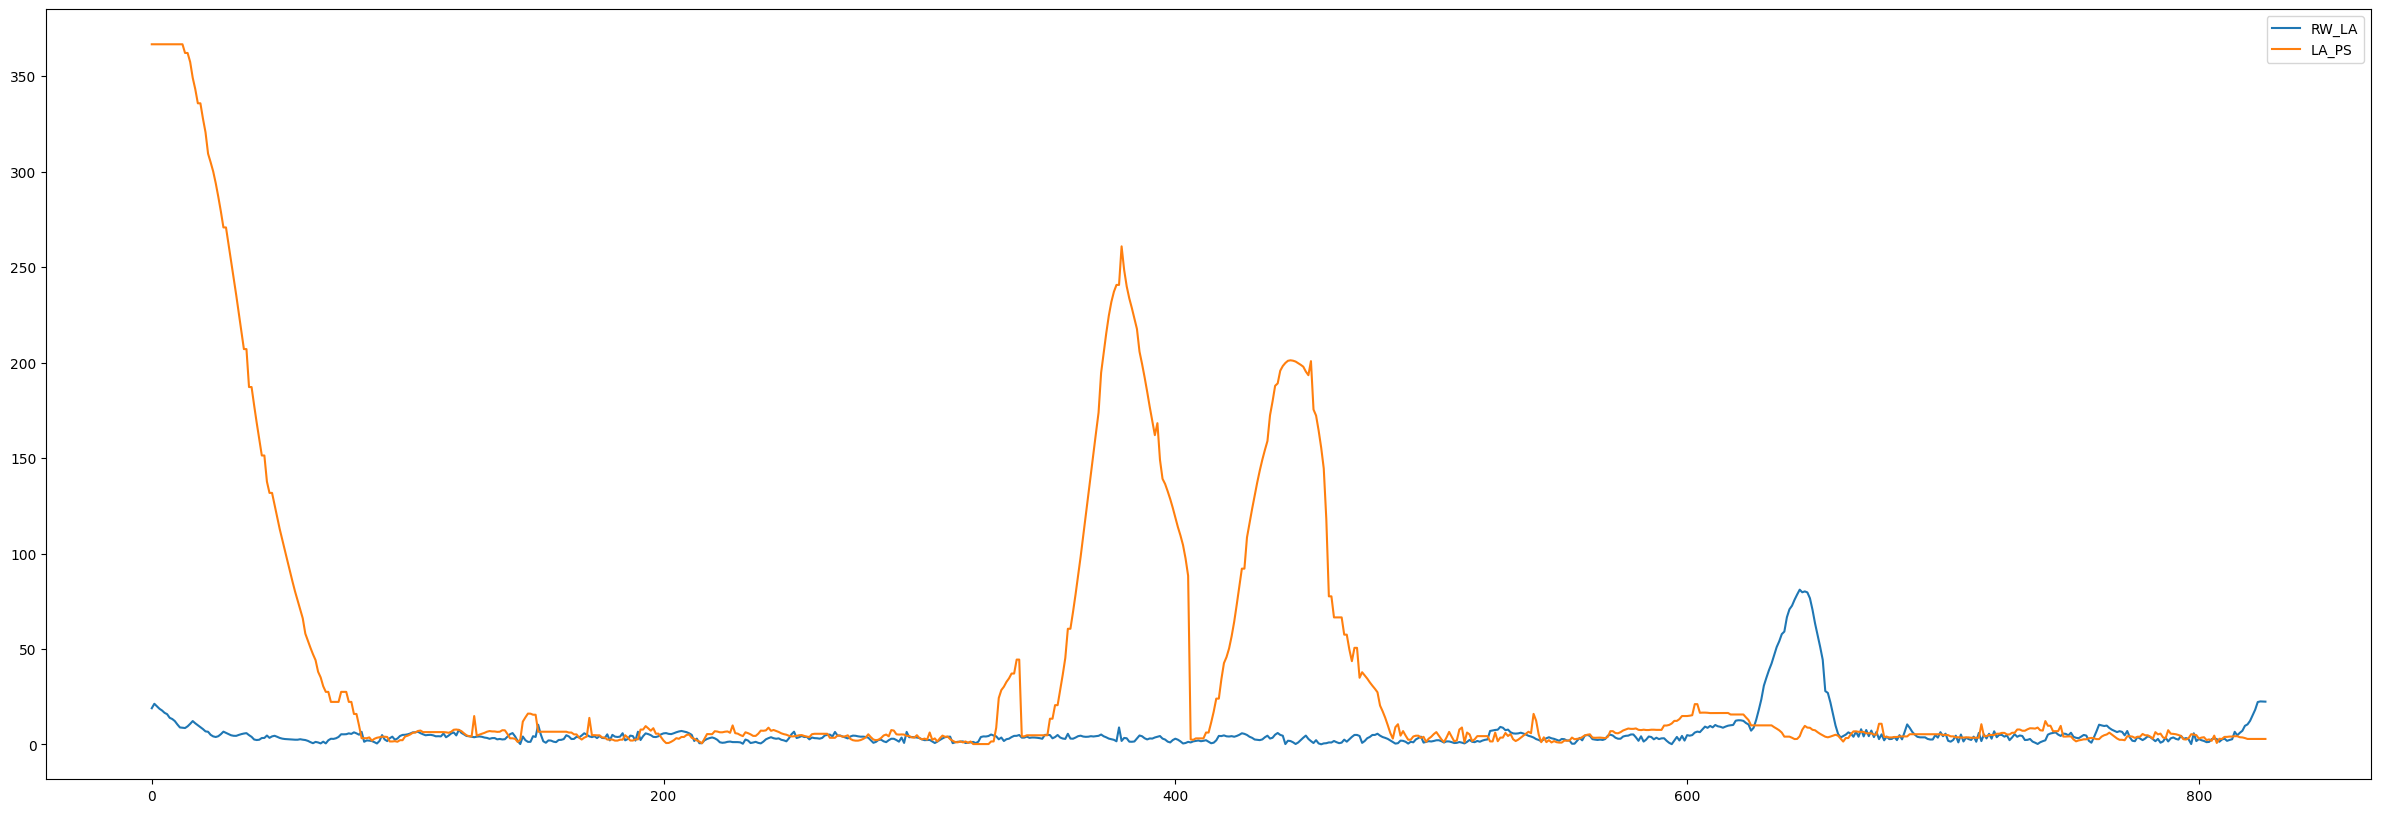

In [18]:
pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS']).plot(figsize=(30,10))

In [19]:
dist_v = pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS']).to_csv('distance_platoon.csv', index=False)

In [20]:
dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)

In [21]:
pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

In [22]:
infr = pd.read_csv('/home/selihadji/Documenti/papers/Platoon_II/infrast_data_update_.csv', sep=';')
infr.what.unique()

array(['Turn_left', '4-ways intersection', 'Traffic_light', 'Curve',
       'Road_immission', 'Turn_right'], dtype=object)

In [23]:
allveic = []
for k in range(0, len(dist_coord.columns)-1, 2):
    veic = []
    for i in range(len(dist_coord)):
        infra = []
        for j in range(len(infr)):
            inf = (infr.iloc[j].lon,infr.iloc[j].lat)
            distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k+1])], dist_coord.iloc[i][str(dist_coord.columns[k])])
            infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
        veic.append(infra)
    allveic.append(veic)

In [24]:
v1 = pd.DataFrame(allveic[0])
v2 = pd.DataFrame(allveic[1])

In [25]:
allfeat = []
for i in range(len(v1)): 
    allfeat.append(list(v1[v1<500].iloc[i].dropna()))
new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [26]:
allfeat = []
for i in range(len(v2)): 
    allfeat.append(list(v2[v2<500].iloc[i].dropna()))
new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [27]:
v1.columns = infr.what
v2.columns = infr.what

In [28]:
vlist = []
vlist.append(v1)
vlist.append(v2)

In [29]:
import statsmodels.api as sm

In [30]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = dist_v[str(dist_v.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.723
Model:                            OLS   Adj. R-squared (uncentered):              0.721
Method:                 Least Squares   F-statistic:                              305.6
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   1.38e-223
Time:                        09:02:35   Log-Likelihood:                         -4372.0
No. Observations:                 827   AIC:                                      8758.
Df Residuals:                     820   BIC:                                      8791.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection    72.8053     11.490      6.337      0.000      50.252      95.358
Feat_Curve                  -5.1070     10.072     -0.507      0.612     -24.878      14.664
Feat_Road_immission          2.0420     10.016      0.204      0.839     -17.619      21.703
Feat_Traffic_light          12.6458      2.279      5.550      0.000       8.173      17.118
Feat_Turn_left             -16.7299      6.048     -2.766      0.006     -28.602      -4.858
Feat_Turn_right              1.7696      6.863      0.258      0.797     -11.701      15.240
old_dist                     0.7991      0.021     38.093      0.000       0.758       0.840
==============================================================================
Omnibus:                      861.217   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43451.908
Skew:                           4.949   Prob(JB):                         0.00
Kurtosis:                      37.103   Cond. No.                         627.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_13_09_12_24_12.csv')

In [32]:
platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] <80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.718
Model:                            OLS   Adj. R-squared (uncentered):              0.715
Method:                 Least Squares   F-statistic:                              297.6
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   3.46e-220
Time:                        09:02:35   Log-Likelihood:                          3743.8
No. Observations:                 827   AIC:                                     -7474.
Df Residuals:                     820   BIC:                                     -7441.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     0.0015      0.001      2.461      0.014       0.000       0.003
Feat_Curve                   0.0018      0.001      3.318      0.001       0.001       0.003
Feat_Road_immission          0.0057      0.001     10.334      0.000       0.005       0.007
Feat_Traffic_light           0.0041      0.000     33.050      0.000       0.004       0.004
Feat_Turn_left               0.0056      0.000     16.794      0.000       0.005       0.006
Feat_Turn_right              0.0073      0.000     19.349      0.000       0.007       0.008
old_dist                  1.411e-06   1.15e-06      1.229      0.219   -8.42e-07    3.66e-06
==============================================================================
Omnibus:                        5.848   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                4.398
Skew:                           0.046   Prob(JB):                        0.111
Kurtosis:                       2.655   Cond. No.                         627.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_13_09_12_24_12_CO2.csv')